# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_20_Agents/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the policy

In [5]:
from ddpg_agent import Agent

train_seed = 42

device_id = 1

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")

# Create agent
agent = Agent(
    state_size=state_size,
    action_size=action_size,
    n_agents=num_agents,
    seed=train_seed,
    device=device,
    buffer_size=int(1e6),
    batch_size=1024,
    gamma=0.99,
    tau=1e-3,
    lr_actor=1e-4,
    lr_critic=3e-4,
    relu_leak=0.01,
    num_updates=10,
    update_every=20
)

In [6]:
def ddpg(
    agent,
    n_episodes=1000,
    max_t=1000, 
    actor_chkpt='checkpoint_actor.pth', 
    critic_chkpt='checkpoint_critic.pth',
    train=True,
    desired_score=30.0,
    desired_average_steps=100
    ):
    
    scores_deque = deque(maxlen=desired_average_steps)
    scores = []
    max_score = -np.Inf
    
    if not train:
        n_episodes = 1
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=train)[brain_name]
        states = env_info.vector_observations       
        agent.reset()
        
        current_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=train, train=train)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            if train:
                agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            current_scores += np.array(rewards)
            if np.any(dones):
                break         
                
        avg_score = np.mean(current_scores)
        scores_deque.append(avg_score)
        scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), avg_score), end="")

        if train:
            
            mean_score_100 = np.mean(scores_deque)
            
            if i_episode % 20 == 0 or mean_score_100 >= desired_score:
                torch.save(agent.actor_local.state_dict(), actor_chkpt)
                torch.save(agent.critic_local.state_dict(), critic_chkpt)
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            if mean_score_100 >= desired_score:         
                print("Desired average score {} over {} episodes reached.".format(desired_score, desired_average_steps))
                break
    print("\n")
            
    return scores

In [7]:
scores = ddpg(agent, n_episodes=300, train=True)

Episode 20	Average Score: 1.46	Score: 1.99
Episode 40	Average Score: 2.66	Score: 5.43
Episode 60	Average Score: 4.81	Score: 14.12
Episode 80	Average Score: 8.36	Score: 24.71
Episode 100	Average Score: 12.69	Score: 33.03
Episode 120	Average Score: 18.92	Score: 31.01
Episode 140	Average Score: 25.10	Score: 35.55
Episode 159	Average Score: 30.09	Score: 35.38
Desired average score 30.0 over 100 episodes reached.




### 4. Plot the scores

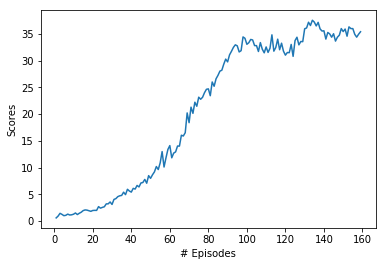

In [8]:
def plot_scores(scores):
    f = plt.figure()
    ax = f.add_subplot(111)
    plt.plot(range(1, len(scores) + 1), scores)
    plt.xlabel('# Episodes')
    plt.ylabel('Scores')
    plt.savefig('scores_plot.png')
    plt.show()
    
plot_scores(scores)

### 5. Watch a smart agent

In [9]:
# Load agent from checkpoint

agent2 = Agent(
    state_size=state_size,
    action_size=action_size,
    n_agents=num_agents,
    seed=123,
    device=device
)

agent2.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))

In [10]:
inference_scores = ddpg(agent2, train=False)

print("Average inference score: {:.2f}".format(np.mean(inference_scores)))

Episode 1	Average Score: 38.89	Score: 38.89

Average inference score: 38.89


When finished, you can close the environment.

In [11]:
env.close()